# Generating Seismograms from Well Logs in Python

Acoustic Impedance is generated through sonic and density well log from each well. In this research, the high frequency wavelet is convolved to generate synthetic from reflectivity series made from acoustic impedance. Several steps are performed in order to successfully accomplish the generation of synthetic of each well.

The following steps are performed:
* Libraries Importation
* Data Loading
* Generation of Acoustic Impedance
* Generation of Reflectivity Series
* Wavelet and Convolution
* Synthetic Visualization

###  1 - Libraries Importation

 Libraries are imported in order to use the modules for the synthetic data generation.

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import natsort

### 2 - Data Loading

Paths are given in order to get the excel format of zamzama files of all wells in order to load them in python.

In [44]:
paths = natsort.natsorted(glob.glob(os.path.join(r"E:\HighFreq-ML\Zamzama\wells","*.csv")))
paths.pop(-1)

'E:\\HighFreq-ML\\Zamzama\\wells\\_10.csv'

Dataframe are exported into the python through path files extracted from the last step.

In [45]:
data =[]
for i in paths:
    r = pd.read_csv(i)
    data.append(r)

### 3 - Generation of Acoustic Impedance

After exporting the datasets of each well, every well is analyzed, density and velocity are used to create acoustic impedance (AI).

In [46]:
a=data[0]
a=a[["amplitude","DPTM","DT","RHOB"]].dropna(how="any")

In [47]:
a["A-I"] = a["DT"]*a["RHOB"]
a["DPTM"] = a["DPTM"]/1000  #conversion of time from milliseconds to seconds
a

,amplitude,DPTM,DT,RHOB,A-I
0,13404.452191,2.139732,3811.4956,2.6288,10019.659633
1,13366.818297,2.139790,5242.6025,2.5888,13572.049352
2,13335.499570,2.139839,5847.6240,2.7191,15900.274418
3,13295.809774,2.139902,5846.7676,2.7242,15927.764296
4,13258.181889,2.139960,5846.8052,2.7240,15926.697365
...,...,...,...,...,...
332,8241.536959,2.168649,4148.8994,2.6076,10818.670075
333,8354.837662,2.168747,4187.4199,2.6038,10903.203936
334,8452.019659,2.168831,4187.3564,2.6032,10900.526180
335,8553.737482,2.168919,4177.3008,2.6060,10886.045885


### 4 - Generation of Reflectivity Series


                                   Reflection cofficient series are generated through zoeppritz equation
$$ R = {Z1 - Z0 \over Z1 + Z0} $$

$$Z = Acoustic    Impedance = ρV$$

Acoustic Impedance is used to create reflectivity series using zoeppritz equation.

In [48]:
dt = 0.0001  #sampling interval
t = np.arange(a["DPTM"].min(), a["DPTM"].max(), dt)  #the samples of time is extracted between minimum and maximum time
AI_time = np.interp(x=t, xp = a.DPTM, fp = a["A-I"])  #interpolation of acoustic impedance at each time of t
Amp_time = np.interp(x=t, xp = a.DPTM, fp = a["amplitude"]) #interpolation of amplitude from seismic data at each time of t

In [49]:
RF=[]
for i in range(len(AI_time)-1):
    z1 = (AI_time[i+1]-AI_time[i])/(AI_time[i]+AI_time[i+1])
    RF.append(z1)
RF.append(RF[-1])

### 5 - Wavelet & Convolution

High frequency wavelet is convolved into the reflectivity series in order to generate synthetic.

In [50]:
def ricker_wavelet(f, length, dt):
    t0 = np.arange(-length/2, (length-dt)/2, dt)
    t_squared = t0**2
    y = (1.0 - 2.0*(np.pi**2)*(f**2)*t_squared) * np.exp(-(np.pi**2)*(f**2)*t_squared)
    return t0, y

In [117]:
f=65       
length=0.0293
dt= 0.0001
t0, w = ricker_wavelet(f, length, dt)  
synthetic = np.convolve(w, RF, mode='same')

### 6 - Synthetic Visualizations

The dataframe consists of the amplitude, acoustic impedance, reflection coefficient series and synthetic at specific interval of time.

In [118]:
new = pd.DataFrame({"Amplitude":Amp_time,"AI":AI_time,"RC":RF,"Synthetic":synthetic,"DPTM":t})

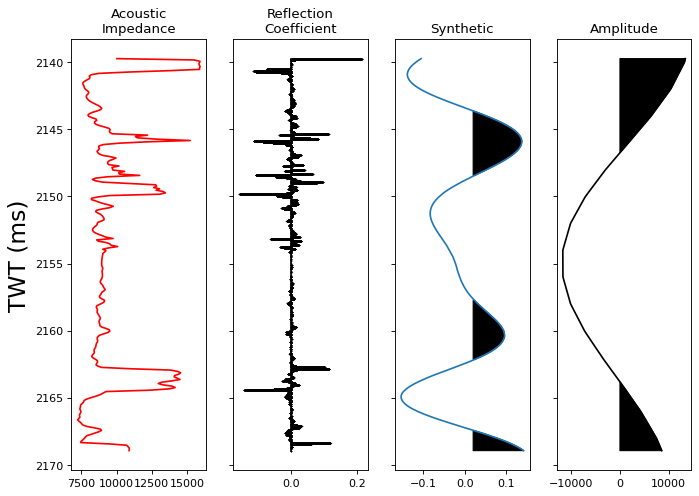

In [119]:
fig, axes = plt.subplots(1, 4, figsize=(10, 7), dpi=80, sharey=True)
axes[0].plot(new["AI"],new["DPTM"]*1000,color="red")
axes[0].set_title("Acoustic\nImpedance")
axes[1].plot([0,0],[new["DPTM"].min()*1000,new["DPTM"].max()*1000],color="black")
axes[1].set_title("Reflection\nCoefficient")
for i,j in zip(new["RC"],new["DPTM"]*1000):
    if i>=0:
        a = np.arange(0,i,0.0001)
        axes[1].scatter(a,j*np.ones(len(a)),color="black",s=0.05)
    else:
        b = np.arange(i,0,0.0001)
        axes[1].scatter(b,j*np.ones(len(b)),color="black",s=0.05)
axes[3].plot(new["Amplitude"],new["DPTM"]*1000,color="black")
axes[3].set_title("Amplitude")
axes[3].fill_betweenx(new["DPTM"]*1000, 0.4 , new["Amplitude"], where=(new["Amplitude"]>0.5),color='k')
axes[2].plot(new["Synthetic"],new["DPTM"]*1000)
axes[2].fill_betweenx(new["DPTM"]*1000, 0.02 , new["Synthetic"], where=(new["Synthetic"]>0.02),color='k')
axes[2].set_title("Synthetic",fontsize=21)
axes[0].set_ylabel("TWT (ms)",fontsize=21)
axes[0].invert_yaxis()
plt.show()

In [ ]:
new.to_csv("synthetic_well_1.csv",index=False)